# Дано

Имеются две базы данных (два листа Excel-файла): база с ценами конкурентов (Data_Parsing) и внутренняя база компании (Data_Company).

В базе парсинга есть два id, однозначно определяющие товар: producer_id и producer_color.

В базе компании есть два аналогичных поля: item_id и color_id.

Нам известно, что коды в двух базах отличаются наличием набора служебных символов. В базе парсинга встречаются следующие символы: _, -, ~, \\, /.

# Задание

- Считать данные из Excel в DataFrame (Data_Parsing) и (Data_Company).  
- Подтянуть к базе парсинга данные из базы компании (item_id, color_id, current_price) и сформировать столбец разницы цен в % (цена конкурента к нашей цене).  
- Определить сильные отклонения от среднего в разности цен в пределах бренда-категории (то есть убрать случайные выбросы, сильно искажающие сравнение). Критерий — по вкусу, написать комментарий в коде.  
- Записать новый файл Excel с базой парсинга, приклееными к ней столбцами из пункта 2 и с учётом пункта 3 (можно добавить столбец outlier и проставить Yes для выбросов).  

# Решение

#### Импорты

In [106]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import re
import seaborn as sns

print('pd:', pd.__version__)
print('np:', np.__version__)
print('plt:', matplotlib.__version__)
print('re:', re.__version__)
print('sns:', sns.__version__)

pd: 2.2.3
np: 2.1.2
plt: 3.9.2
re: 2.2.1
sns: 0.13.2


#### Функции

In [182]:
def low_information_analize(df: pd.DataFrame, freq: float=0.95) -> list:
    """
    Возвращает список неинформативных признаков и их частоту
    """
    low_information_cols = [] 
    
    # Цикл по всем столбцам
    for col in df.columns:
        # Наибольшая относительная частота в признаке
        top_freq = df[col].value_counts(normalize=True).max()
        # Доля уникальных значений от размера признака
        nunique_ratio = df[col].nunique() / df[col].count()
        # Сравниваем наибольшую частоту с порогом
        if top_freq > freq:
            low_information_cols.append(col)
            print(f'{col}: {round(top_freq * 100, 2)}% одинаковых значений')
        # сравниваем долю уникальных значений с порогом
        if nunique_ratio > freq:
            low_information_cols.append(col)
            print(f'{col}: {round(nunique_ratio * 100, 2)}% уникальных значений')
            
    return low_information_cols

def outliers_sigma_mod(data, feature=None, log_scale=False, log_zeroes=False,  left:int=3, right:int=3) -> tuple:
    """
    Возвращает список неинформативных признаков по методу сигм и их частоту

    Returns:
        - outliers, cleaned
    """
    elements = data[feature] if feature else data
    if log_scale:
        val: pd.DataFrame = np.log(elements + (1 if log_zeroes else 0)) # +1 нужен для обработки нулевых значений
    else:
        val: pd.DataFrame = elements
    mu = val.mean()
    sigma = val.std()
    lower_bound = mu - left * sigma
    upper_bound = mu + right * sigma
    # print(mu, sigma, lower_bound, upper_bound)
    outliers = data[(val < lower_bound) | (val > upper_bound)]
    cleaned = data[(val >= lower_bound) & (val <= upper_bound)]
    return outliers, cleaned

def outliers_iqr_mod(data, feature=None, log_scale=False, log_zeroes=False, left=1.5, right=1.5):
    """
    Возвращает список неинформативных признаков по методу Тьюки (межквартильный размах]) и их частоту
    """
    elements = data[feature] if feature else data
    if log_scale:
        val = np.log(elements + (0 if not log_zeroes else 1))
    else:
        val = elements
    quartile_1, quartile_3 = val.quantile(0.25), val.quantile(0.75),
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * left)
    upper_bound = quartile_3 + (iqr * right)
    outliers = data[(val < lower_bound) | (val > upper_bound)]
    cleaned = data[(val >= lower_bound) & (val <= upper_bound)]
    return outliers, cleaned

def df_col_is_string(x): 
    """
    Функция роверяет, что значение x - строка
        На данный момент только методом isinstance
    """    
    return isinstance(x, str)

def apply_outliers(data: pd.DataFrame, outliers: pd.DataFrame):
    display(data)
    display(outliers)
    for idx in outliers.index():
        print(idx)
        result = data.drop([idx])
    display(result)
    return result


#### Подготовка данных

In [108]:

data_company = pd.read_excel('data/Data_TSUM.xlsx', sheet_name='Data_Company');
data_parsed = pd.read_excel('data/Data_TSUM.xlsx', sheet_name='Data_Parsing');

data_parsed_replacement_mask = r'[_\-\~\\/]+'

cols = data_parsed.columns
for col in cols:
    is_string_series = data_parsed[col].apply(df_col_is_string)
    if(True in set(is_string_series)):
        data_parsed[col] = data_parsed[col].apply(lambda el: re.sub(data_parsed_replacement_mask, '', el))

cols_to_use = data_company.columns.difference(data_parsed.columns)
data_merged = data_parsed.merge(
    data_company[cols_to_use], 
    left_on=['producer_id', 'producer_color'],
    right_on=['item_id', 'color_id'],

).drop(['item_id','color_id'], axis=1).reindex()

data_merged['brand'] = data_merged['brand'].astype('category')
data_merged['Category'] = data_merged['Category'].astype('category')
data_merged['diff'] = data_merged['current price'] * 100 / data_merged['price']
# data_merged['diff'] = round(data_merged['current price'] * 100 / data_merged['price'], 0)

low_information_cols = low_information_analize(data_merged)
print(low_information_cols)

display(data_merged.head(3))
display(data_merged.info())

producer_id: 100.0% уникальных значений
diff: 100.0% уникальных значений
['producer_id', 'diff']


,brand,Category,producer_id,producer_color,price,current price,diff
0,Valentino,Shoes,aaaaa111111,black,167,247,147.904192
1,Valentino,Shoes,aaaaa111112,black,188,161,85.638298
2,Valentino,Shoes,aaaaa111113,black,184,234,127.173913


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75 entries, 0 to 74
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   brand           75 non-null     category
 1   Category        75 non-null     category
 2   producer_id     75 non-null     object  
 3   producer_color  75 non-null     object  
 4   price           75 non-null     int64   
 5   current price   75 non-null     int64   
 6   diff            75 non-null     float64 
dtypes: category(2), float64(1), int64(2), object(2)
memory usage: 3.5+ KB


None

Игнорируем данные по признаку producer_id и producer_color так как это совокупный уникальный идентификатор товара

#### Анализ

In [109]:
data_merged['diff'].describe()

count     75.000000
mean     105.211842
std       29.495870
min       59.375000
25%       84.807692
50%      103.846154
75%      123.255263
max      172.352941
Name: diff, dtype: float64

По общему описанию признака 'diff' особых аномалий не обнаруживается

Работаем жостко.  
Будем искать выбросы по стандартным медодам Тьюки (1.5) и сигм (3.0). Всё что попадёт в их комбинированные выбросы - выкидываем.

Brioni > Bags
min: 61, mean: 102, max: 156
Нет выбросов
Brioni > Shoes
min: 61, mean: 101, max: 151
Выбросы


,brand,Category,producer_id,producer_color,price,current price,diff
30,Brioni,Shoes,bbbbb111116,black,190,283,148.947368
32,Brioni,Shoes,bbbbb111118,white,165,235,142.424242
34,Brioni,Shoes,bbbbb111120,white,169,256,151.479290


,brand,Category,producer_id,producer_color,price,current price,diff
0,Valentino,Shoes,aaaaa111111,black,167,247,147.904192
1,Valentino,Shoes,aaaaa111112,black,188,161,85.638298
2,Valentino,Shoes,aaaaa111113,black,184,234,127.173913
3,Valentino,Shoes,aaaaa111114,black,196,167,85.204082
4,Valentino,Shoes,aaaaa111115,black,250,153,61.200000
...,...,...,...,...,...,...,...
70,Stone Island,Bags,sssss111131,red,164,165,100.609756
71,Stone Island,Bags,sssss111132,red,158,196,124.050633
72,Stone Island,Bags,sssss111133,red,194,236,121.649485
73,Stone Island,Bags,sssss111134,red,256,222,86.718750


,brand,Category,producer_id,producer_color,price,current price,diff
30,Brioni,Shoes,bbbbb111116,black,190,283,148.947368
32,Brioni,Shoes,bbbbb111118,white,165,235,142.424242
34,Brioni,Shoes,bbbbb111120,white,169,256,151.479290


brand


KeyError: "['brand'] not found in axis"

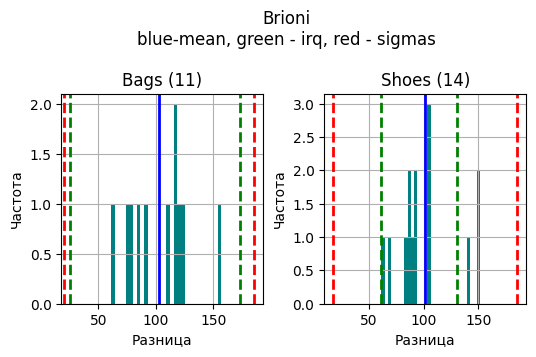

In [181]:
data_groupped_brand = data_merged.groupby(['brand',], observed=False)
data_groupped_brand_cat = data_merged.groupby(['brand','Category'], observed=False)

for brand in data_groupped_brand.groups.keys():
    # print(brand)
    category_data = data_groupped_brand.get_group((brand,)).groupby(['Category'], observed=False)
    plot_cols = len(category_data.groups.keys())
    plot_idx = -1
    figure, axes = plt.subplots(nrows=1, ncols=plot_cols, figsize=(3 * plot_cols, 3))
    figure.suptitle(f'{brand}\nblue-mean, green - irq, red - sigmas')
    plt.subplots_adjust(top=0.7, bottom=0, wspace=0.3, hspace=0.4)
    for category in category_data.groups.keys():
        plot_idx += 1
        print(f'{brand} > {category}')

        elements = data_groupped_brand_cat.get_group((brand, category))
        # display(elements)
        print(f'min: {int(elements["diff"].min())}, mean: {int(elements["diff"].mean())}, max: {int(elements["diff"].max())}')

        plot = elements['diff'].plot(
            kind='hist', 
            bins=30,
            title=f'{category} ({len(elements)})',
            # x='diff',
            ax=axes[plot_idx],
            color='teal',
            grid=True,
            xlabel='Разница',
            ylabel='Частота',
            legend=False, 
        )

        left_irq, right_irq = 1.5, 1.5
        left_sigma, right_sigma = 3, 3
        quartile_1, quartile_3 = elements['diff'].quantile(0.25), elements['diff'].quantile(0.75),
        iqr = quartile_3 - quartile_1
        lower_bound = quartile_1 - (iqr * left_irq)
        upper_bound = quartile_3 + (iqr * right_irq)
        plot.axvline(elements['diff'].mean(), color='b', lw=2)
        # Limits for irq method
        plot.axvline(lower_bound, color='g', ls='--', lw=2)
        plot.axvline(upper_bound, color='g', ls='--', lw=2)
        # Limits for 3-sigmas method
        plot.axvline(elements['diff'].mean() + right_sigma * elements['diff'].std(), color='r', ls='--', lw=2)
        plot.axvline(elements['diff'].mean() - left_sigma * elements['diff'].std(), color='r', ls='--', lw=2)

        outliers_irq, cleaned_irq = outliers_iqr_mod(elements, 'diff')
        outliers_sigma, cleaned_sigma = outliers_sigma_mod(elements, 'diff')
        if(len(outliers_irq) or len(outliers_sigma)):
            print('Выбросы')
            if(len(outliers_irq)):
                display(outliers_irq)
                data_wo_outliers = apply_outliers(data_merged, outliers_irq)
            if(len(outliers_sigma)):
                display(outliers_sigma)
        else:
            print('Нет выбросов')

    plt.show()

